# Imports

In [348]:
# shows the output of every line evaluated in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import numpy as np
import yfinance as yf
pd.set_option("display.precision", 2)

# sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage

# scipy
from scipy.cluster.hierarchy import fcluster

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# plotting config
sns.set(style="darkgrid")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.rc('figure', figsize=(12,8))
plt.rc('lines', markersize=4)
plt.rc('font', size=30)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=20)
plt.rcParams["figure.autolayout"] = True

In [349]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

# Abstract

In this project will apply clustering algorithms in the stocks contained in the S&P500 index. First, will import the closing price of all 503 stocks needed from the yfinance API. We will clean it up and then preprocess it. Next, we will train and optimize a K means model, Hierachical Clustering model and a DBSCAN density based clustering model in order to gain further insight from the stocks contained in S&P500. Finally, we will evaluate the models and discuss next steps.

# Intro

In Quant Finance there is the sector called algorithmic trading where a systematic use programming is applied to trading. In this way, we can devise and automate strategies in order to optimize profit. 

Optimization and Risk analysis of portfolios is a big sector of algo trading where we study portfolios to asses performance and risks.  One of the many ways to analyse a porfolio is by applying clustering techniques to its stocks. In this way we can gain more insight as to how we assign weights to each stock and how to maintain a portfolio.

In this project we will showcase 3 clustering techniques on the S&P 500 index.

# Data

## Data Description

The data will eventually consist only from the close price of stocks.

## Data Collection

Scrape the html table from the wiki of S&P500

In [3]:
table = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")

The first table includes the symbols

In [4]:
table

[    Symbol              Security SEC filings             GICS Sector  \
 0      MMM                    3M     reports             Industrials   
 1      AOS           A. O. Smith     reports             Industrials   
 2      ABT                Abbott     reports             Health Care   
 3     ABBV                AbbVie     reports             Health Care   
 4     ABMD               Abiomed     reports             Health Care   
 ..     ...                   ...         ...                     ...   
 498    YUM           Yum! Brands     reports  Consumer Discretionary   
 499   ZBRA    Zebra Technologies     reports  Information Technology   
 500    ZBH         Zimmer Biomet     reports             Health Care   
 501   ZION  Zions Bancorporation     reports              Financials   
 502    ZTS                Zoetis     reports             Health Care   
 
                       GICS Sub-Industry    Headquarters Location  \
 0              Industrial Conglomerates    Saint Pau

Specifically the first column contains all the symbols

In [5]:
table[0].head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


In [24]:
tickers_snp500 = table[0].drop(table[0].columns.drop('Symbol'), axis=1).sort_values(by='Symbol')

In [26]:
tickers_snp500.head()

,Symbol
13,A
30,AAL
10,AAP
45,AAPL
3,ABBV


In total there are 503 stocks in S&P500

In [27]:
tickers_snp500.shape

(503, 1)

In [28]:
tickers_chunked = [x.flatten().tolist() for x in np.array_split(tickers_snp500.values, 20)]

In [29]:
len(tickers_chunked)

20

In [134]:
df = []
for tickers in tickers_chunked:
    try:
        ticker = yf.download(tickers=tickers)
    except:
        pass
    else:
        df += [ticker]
df = pd.concat(df, axis=1).swaplevel(0,1, axis=1)

# store data ~ 350mb
# df.to_csv("sp500.csv")

# We keep only the Close price
df = df.loc[:, df.columns.get_level_values(1)=='Close'].droplevel(1, axis=1).sort_index()

[*********************100%***********************]  26 of 26 completed
[*********************100%***********************]  26 of 26 completed
[*********************100%***********************]  26 of 26 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
[*************

## Data Cleaning

All tickers seem to be downloaded

In [139]:
tickers_snp500.nunique().values[0] == df.columns.get_level_values(0).nunique()

True

but not all of them have values, some are completely empty, so we filter them out

In [146]:
for col in df.columns:
    if df.loc[:, df.columns.get_level_values(0) == col].isna().all().all():
        df = df.drop(df.loc[:, df.columns.get_level_values(0) == col].columns, axis=1)

In [147]:
df.columns.get_level_values(0).nunique()

501

Two tickers were completely empty

In [148]:
np.setdiff1d(tickers_snp500['Symbol'].unique(), df.columns.get_level_values(0).unique())

array(['BF.B', 'BRK.B'], dtype=object)

We will also narrow down the dates since we downloaded the complete historical data for each stock

In [261]:
df.index.min(), df.index.max()

(Timestamp('1962-01-02 00:00:00'), Timestamp('2022-12-02 00:00:00'))

the starting date will be 2017-01-01

In [265]:
df = df[df.index > pd.Timestamp('2017-01-01 00:00:00')]

Since there are a lot of NaN values we will drop stocks that have more than 30% missing values

In [275]:
nan_tickers = df.isnull().mean().sort_values(ascending=False)
nan_tickers

CEG     0.85
OGN     0.74
OTIS    0.54
CARR    0.54
CTVA    0.40
        ... 
ES      0.00
EQT     0.00
EQR     0.00
EQIX    0.00
ZTS     0.00
Length: 501, dtype: float64

In [281]:
nan_tickers[nan_tickers>0.30].sort_values()

MRNA    0.33
FOXA    0.37
FOX     0.37
DOW     0.37
CTVA    0.40
OTIS    0.54
CARR    0.54
OGN     0.74
CEG     0.85
dtype: float64

In [285]:
drop_cols = nan_tickers[nan_tickers>0.30].index
drop_cols

Index(['CEG', 'OGN', 'OTIS', 'CARR', 'CTVA', 'DOW', 'FOX', 'FOXA', 'MRNA'], dtype='object')

In [290]:
df = df.drop(drop_cols, axis=1)

Fill in the remaining null/nan values

- 'ffill' stands for 'forward fill' and will propagate last valid observation forward

In [298]:
df=df.fillna(method='ffill')

The dataset df is now ready for analysis

## Exploratory Data Analysis

We calculate the standard statistical quantities

In [299]:
df.describe()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
count,1491.00,1491.00,1491.00,1491.00,1491.00,1491.00,1491.00,1491.00,1491.00,1491.00,...,1491.00,1491.00,1491.00,1491.00,1491.00,1491.00,1491.00,1491.00,1491.00,1491.00
mean,94.61,28.85,158.85,87.42,99.73,102.41,263.83,86.90,35.86,214.80,...,112.93,59.10,71.13,51.17,82.44,98.51,124.70,264.43,48.72,126.74
std,33.79,13.53,36.31,47.91,25.74,23.38,80.84,26.68,7.16,72.74,...,33.58,10.18,16.97,10.15,20.77,18.89,16.45,147.09,9.34,48.51
min,46.49,9.04,75.03,29.00,60.00,70.76,104.10,39.05,22.24,113.21,...,43.02,40.29,31.45,26.83,47.00,56.52,78.28,82.61,24.08,52.51
25%,67.38,16.63,138.01,43.85,80.66,85.67,190.49,62.94,30.33,157.24,...,85.67,48.44,60.36,43.38,68.53,83.09,112.92,149.79,43.44,84.74
50%,79.30,27.36,157.66,66.04,94.47,92.60,272.61,85.27,33.21,193.81,...,113.05,62.00,76.18,53.06,78.33,98.98,120.17,225.61,49.33,125.91
75%,125.82,41.26,180.03,134.87,113.72,118.11,323.27,109.94,41.48,278.69,...,134.07,67.91,82.05,58.73,92.94,115.12,134.85,346.90,54.37,163.13
max,179.28,58.47,241.91,182.01,174.96,173.99,449.75,141.46,60.60,415.42,...,201.51,77.41,114.18,69.12,138.03,138.86,173.41,614.55,74.31,247.03


We find the max and min values from each statistical measure from .describe()

In [302]:
maxmin = pd.concat(
    [
        df.describe().agg('idxmax', axis=1).to_frame().rename({0:'max_idx'}, axis=1), 
        df.describe().agg('max', axis=1).to_frame().rename({0:'max_value'}, axis=1),
        df.describe().agg('idxmin', axis=1).to_frame().rename({0:'min_idx'}, axis=1), 
        df.describe().agg('min', axis=1).to_frame().rename({0:'min_value'}, axis=1),        
    ], 
    axis=1
).T
maxmin

,count,mean,std,min,25%,50%,75%,max
max_idx,A,NVR,NVR,NVR,NVR,NVR,NVR,NVR
max_value,1491.0,3610.21,967.65,1649.99,2807.2,3543.3,4362.27,5959.33
min_idx,CDAY,AMCR,AMCR,ENPH,ENPH,F,AMCR,AMCR
min_value,1161.0,11.08,1.05,0.7,4.76,11.12,11.79,13.49


NVR assumes the highest close price in all mean, std, min, 25%,	50%, 75%, max

AMCR assumes the lowest close prince in all mean, std, 75%,	max

## Returns, Mean-Variance

Average Annual Returns

In [319]:
df.pct_change().mean() * 252

A       0.24
AAL    -0.04
AAP     0.05
AAPL    0.32
ABBV    0.20
        ... 
YUM     0.15
ZBH     0.08
ZBRA    0.27
ZION    0.10
ZTS     0.22
Length: 492, dtype: float64

Annual Volatility

In [321]:
df.pct_change().std() * np.sqrt(252)

A       0.28
AAL     0.58
AAP     0.36
AAPL    0.31
ABBV    0.27
        ... 
YUM     0.25
ZBH     0.30
ZBRA    0.39
ZION    0.37
ZTS     0.26
Length: 492, dtype: float64

Combine them in a dataframe

In [326]:
Xy = pd.concat(
    [
    (df.pct_change().mean() * 252).to_frame().rename({0:'Returns'}, axis=1),  
    (df.pct_change().std() * np.sqrt(252)).to_frame().rename({0:'Volatility'}, axis=1) 
        
    ],
    axis=1
)
Xy

,Returns,Volatility
A,0.24,0.28
AAL,-0.04,0.58
AAP,0.05,0.36
AAPL,0.32,0.31
ABBV,0.20,0.27
...,...,...
YUM,0.15,0.25
ZBH,0.08,0.30
ZBRA,0.27,0.39
ZION,0.10,0.37


## Data Preprocessing

We standardize the data, in order to avoid dominance of features with large values.

In [329]:
scaler = StandardScaler()

In [330]:
Xy_scaled = scaler.fit(Xy)

In [332]:
Xy_scaled = pd.DataFrame(Xy_scaled.fit_transform(Xy),columns = Xy.columns, index = Xy.index)
Xy_scaled

,Returns,Volatility
A,0.76,-0.67
AAL,-1.63,2.59
AAP,-0.91,0.18
AAPL,1.44,-0.27
ABBV,0.40,-0.72
...,...,...
YUM,-0.01,-0.99
ZBH,-0.62,-0.40
ZBRA,1.00,0.55
ZION,-0.46,0.29


Comparing before and after standardization

In [338]:
pd.concat(
    [
        pd.concat({'Xy':Xy}, axis=1),
        pd.concat({'Xy Scaled':Xy_scaled}, axis=1)
    ], 
    axis=1
)

Xy            Xy Scaled           
     Returns Volatility   Returns Volatility
A       0.24       0.28      0.76      -0.67
AAL    -0.04       0.58     -1.63       2.59
AAP     0.05       0.36     -0.91       0.18
AAPL    0.32       0.31      1.44      -0.27
ABBV    0.20       0.27      0.40      -0.72
...      ...        ...       ...        ...
YUM     0.15       0.25     -0.01      -0.99
ZBH     0.08       0.30     -0.62      -0.40
ZBRA    0.27       0.39      1.00       0.55
ZION    0.10       0.37     -0.46       0.29
ZTS     0.22       0.26      0.54      -0.82

[492 rows x 4 columns]

The target is are the indices and the values are the columns of Xy_scaled

In [339]:
X, y = Xy_scaled, Xy_scaled.index

# Classifiers

For the analysis the following classifiers will be used:
1. K Means
2. Hierachical Clustering
3. DBSCAN

## K Means

### Optimal number of clusters

We first calculate for k in [2,30] the inertia and silhouette coefficient

In [ ]:
inertia = []
silhouette = []

max_k = 30
random_state = 101
k_list = range(2, max_k)

for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=101);
    kmeans.fit(X)
    inertia += [kmeans.inertia_]
    silhouette += [metrics.silhouette_score(X, kmeans.labels_, random_state=random_state)]

We plot both the inertia and silhouette coefficient

Text(0, 0.5, 'Inertia')

Text(0, 0.5, 'silhouette')

Text(0.5, 0, 'Number of Clusters')

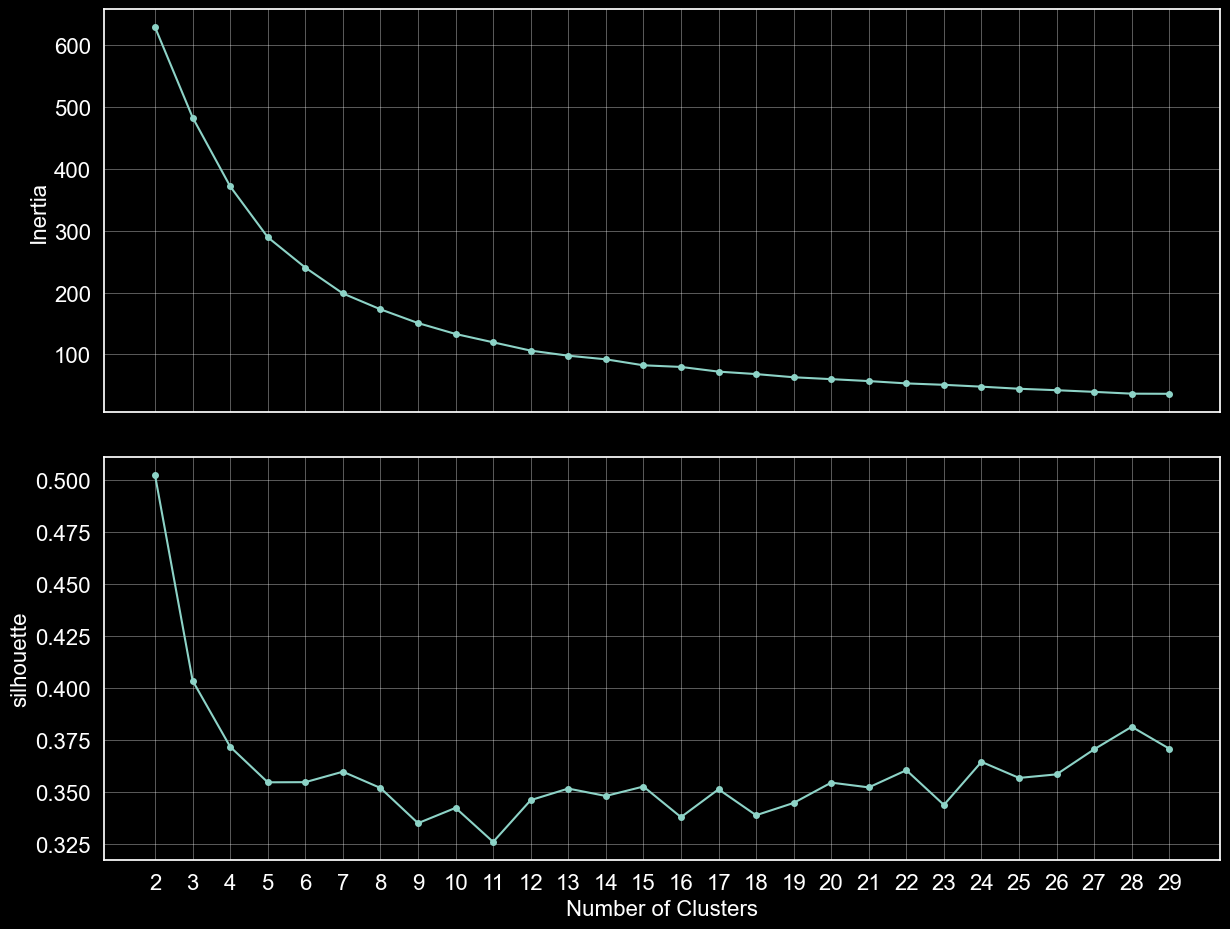

In [388]:
fig, axes = plt.subplots(2, 1, figsize=(13, 10), sharex=True);

axes[0].plot(k_list, inertia)
axes[0].scatter(k_list, inertia)
axes[0].set_ylabel('Inertia')


axes[1].plot(k_list, silhouette)
axes[1].scatter(k_list, silhouette)
axes[1].set_ylabel('silhouette')

axes[1].set_xlabel('Number of Clusters')
axes[1].set_xticks(k_list)


As it is evident the optimal choice of k falls in between 5-7.

We pick k=6 for our analysis.

In [395]:
k_opt = 6
kmeans = KMeans(n_clusters=k_opt, random_state=101);
kmeans.fit(X)

KMeans(n_clusters=6, random_state=101)

### Visualize the clusters

First we define the function cluster_info which gathers all the cluster info
- (x, y) are the centroid coordinates of each cluster
- counts are how many points each cluster has
- the index contains the cluster labels

In [502]:
def cluster_info(clsfr) -> pd.DataFrame:
    """Categorizes all the relevant cluster info of a kmeans model.

    Args:
        clsfr (_type_): kmeans classifier

    Returns:
        pd.DataFrame: columns [x,y,counts] where (x,y) are the cluster center coordinates and the index are the cluster labels
    """
    return pd.concat(
        [
            pd.DataFrame(kmeans.cluster_centers_, columns=['x','y']),
            pd.DataFrame(
                pd.DataFrame(kmeans.labels_).value_counts()
                .sort_index().values, columns=['Counts']
            )
        ],
        axis=1
    )   

In [503]:
cluster_df = cluster_info(kmeans) 
cluster_df

,x,y,Counts
0,-0.94,0.50,84
1,-0.52,-0.76,153
2,1.03,0.97,62
3,0.44,-0.38,165
4,-0.25,2.52,22
5,4.58,3.46,6


<BarContainer object of 6 artists>

Text(0.5, 0, 'Cluster labels')

Text(0, 0.5, 'Counts')

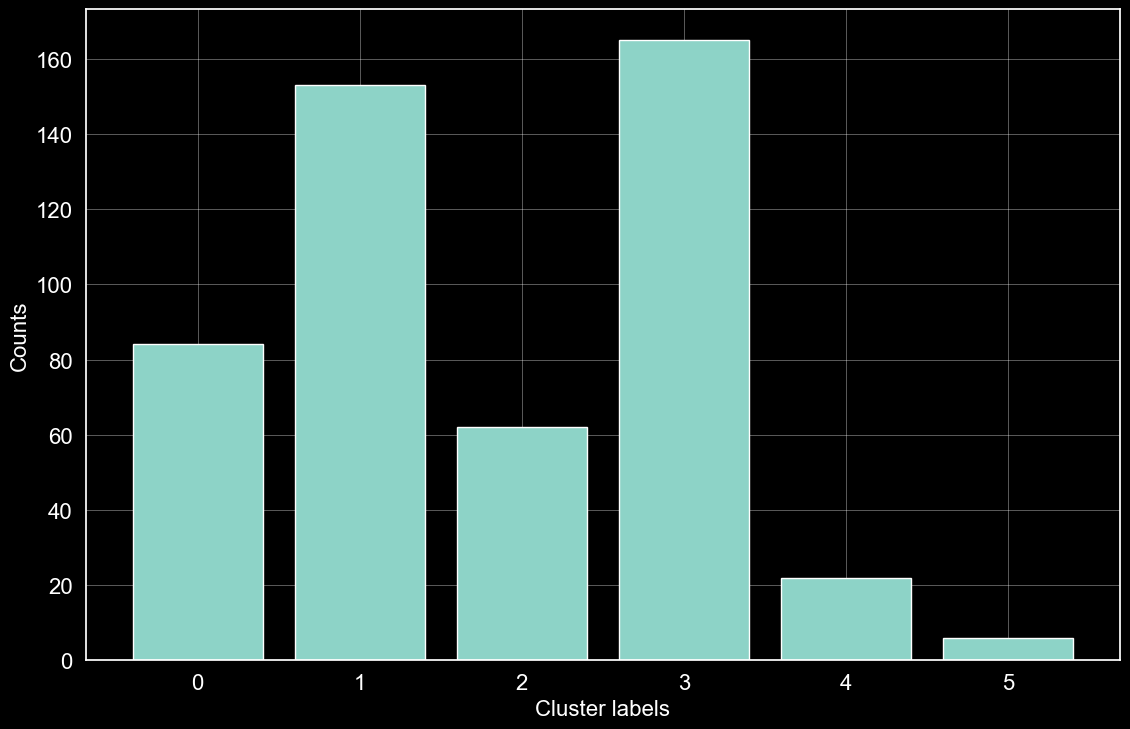

In [591]:
plt.bar(x = cluster_df.index, height=cluster_df['Counts'])
plt.xlabel('Cluster labels')
plt.ylabel('Counts')

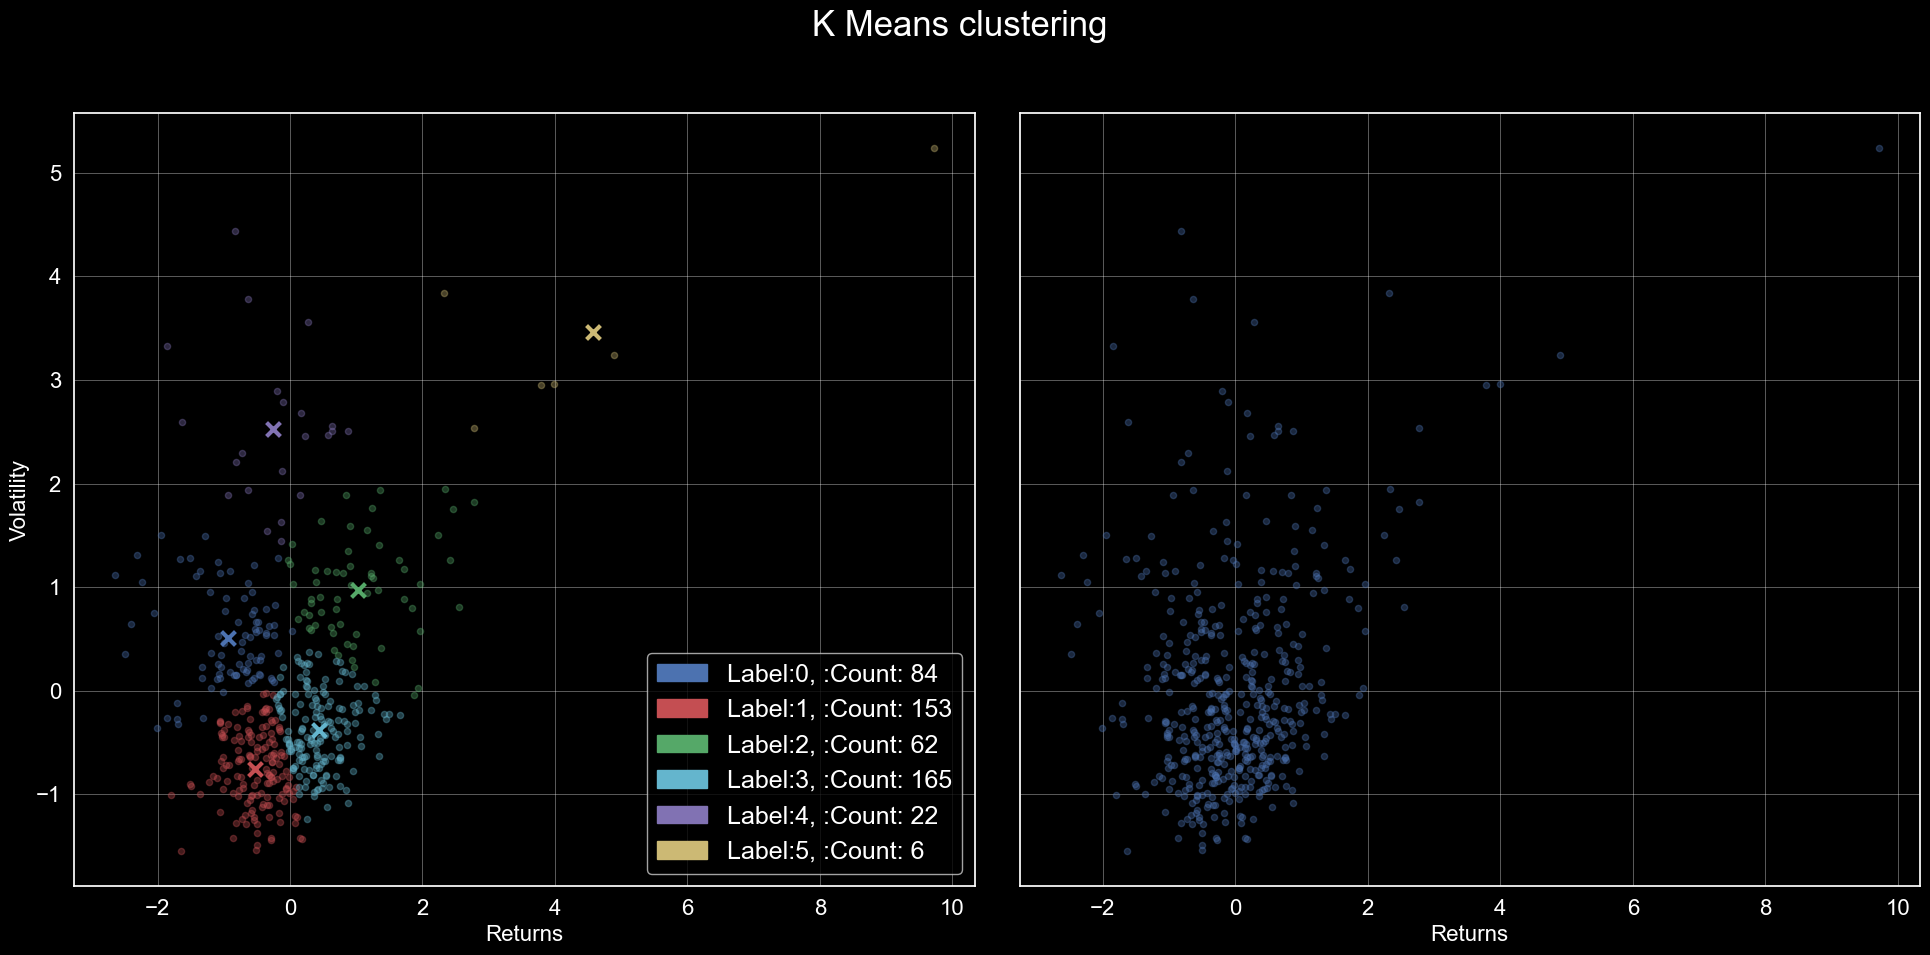

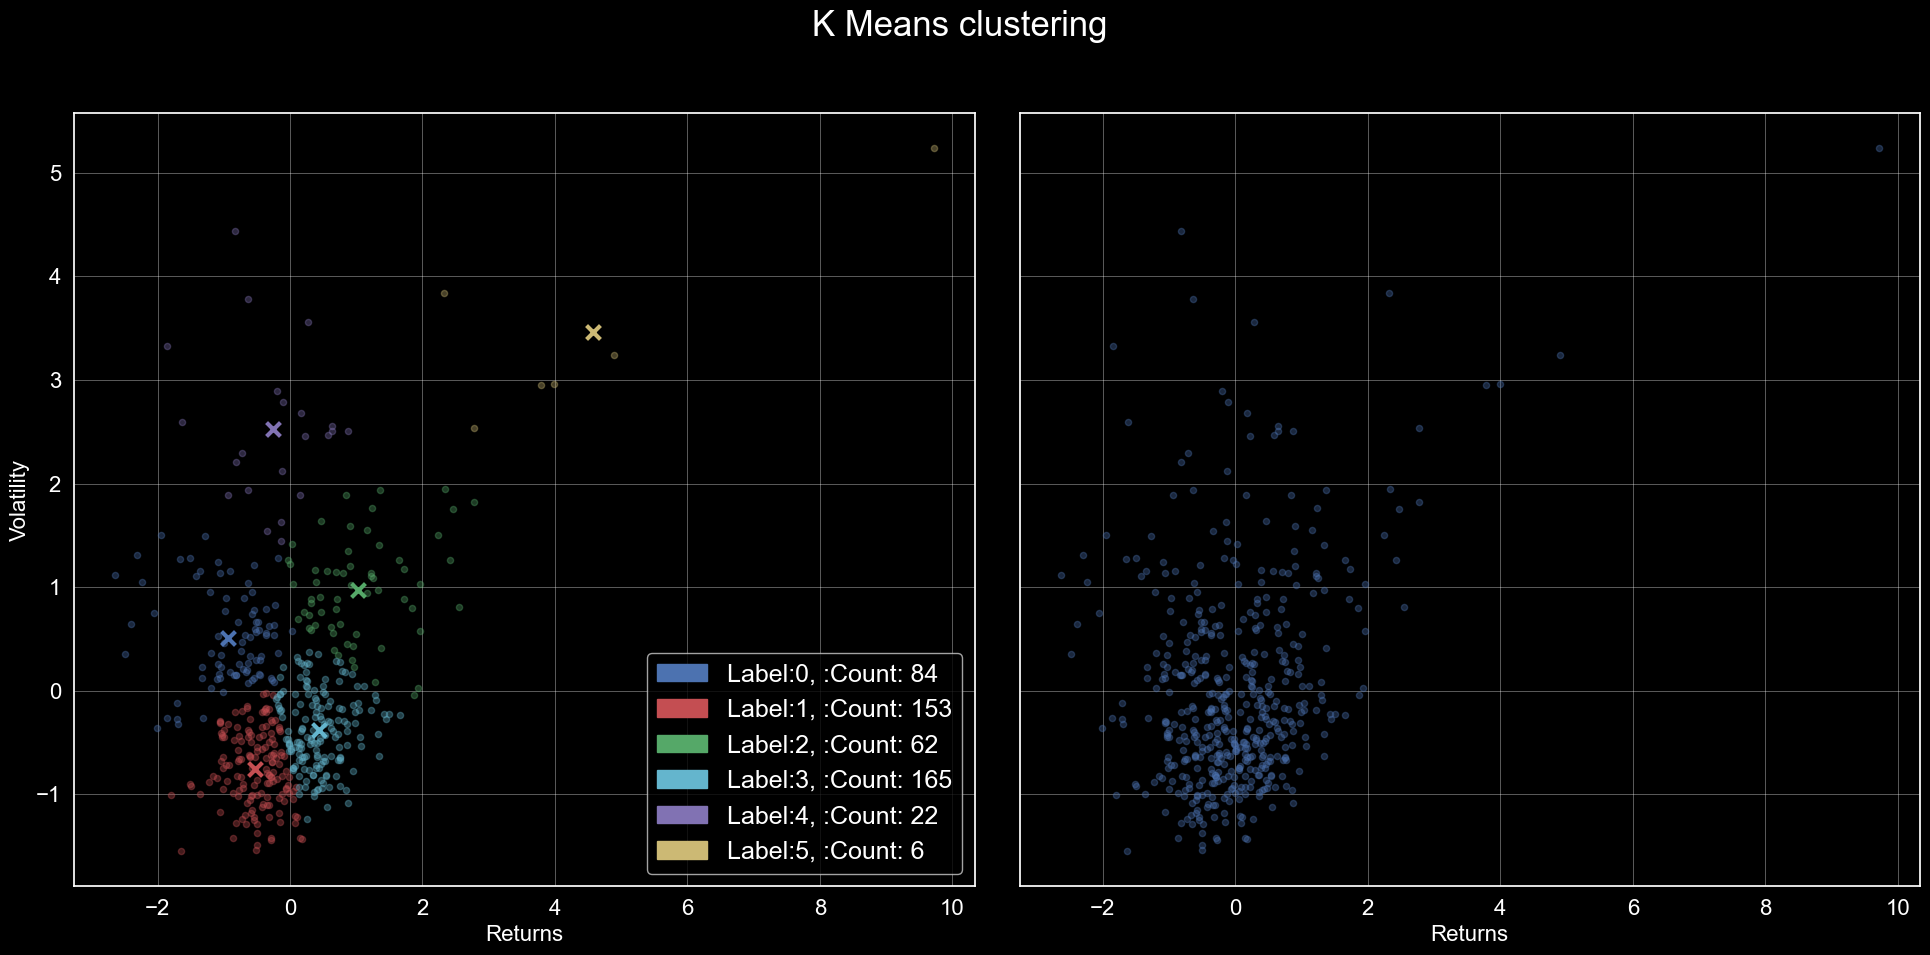

In [613]:
def display_cluster(X, clsf):
    """Displays the 2-D input X colored by the clusters of clsf. The centers of the clusters are also included.

    Args:
        X (_type_): input variable
        clsf (_type_): kmeans classifier
    """    
    cluster_df = cluster_info(clsf)
    color = 'brgcmyk'
    alpha = 0.35
    s = 20
    
    if (cluster_df.shape[0] == 0):
        plt.scatter(X[:,0], X[:,1], c = color[0], alpha = alpha, s = s)
    else:
        patches = []
        
        fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True);
        
        for label in cluster_df.index:
            
            axes[0].scatter(
                x = X[clsf.labels_ == label]['Returns'], 
                y = X[clsf.labels_== label]['Volatility'], 
                c = color[label], alpha = alpha, s=s,
            );
            
            axes[0].scatter(
                x = cluster_df['x'][label],
                y = cluster_df['y'][label], 
                c = color[label], marker = 'x', s = 100,
                linewidths=3
            );
            
            # axes[0].annotate(
            #     cluster_df['Counts'][label], 
            #     (cluster_df['x'][label], cluster_df['y'][label] + 0.1), 
            #     c = color[label], fontsize=20, alpha = 1
            # );
            
            patches += [
                mpatches.Patch(
                    color=color[label], 
                    label=f"Label:{label}, :Count: {cluster_df['Counts'][label]}",
                )
            ];
        axes[0].legend(handles=patches);
        axes[0].set_xlabel(X.columns[0]);
        axes[0].set_ylabel(X.columns[1]);            
        axes[1].scatter(x = X['Returns'], y = X['Volatility'], c = color[0], alpha = alpha, s = s);
        axes[1].set_xlabel(X.columns[0]);
        fig.suptitle('K Means clustering ', fontsize=25)   


        return fig;

display_cluster(X, kmeans)        

- It seems that most stocks belong to Label 3 and Label 1.
- Labels 1 and 3 have the least volatility.

## Hierachical Clustering

### Dendrogram

We first calculate the linkage

In [593]:
Z= linkage(X, method='ward')
Z[0]

array([3.40000000e+01, 3.47000000e+02, 1.80522882e-03, 2.00000000e+00])

Then we use the linkage to visualize the dendrogram which is essentially a cluster tree.
- The leaves are the stocks.
- The root is the final single cluster.
- The distance between clusters is the y axis.

<Figure size 1000x700 with 0 Axes>

Text(0.5, 1.0, 'Stocks Dendrograms')

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [25.0, 25.0, 42.5, 42.5],
  [10.0, 10.0, 33.75, 33.75],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [95.0, 95.0, 105.0, 105.0],
  [115.0, 115.0, 125.0, 125.0],
  [100.0, 100.0, 120.0, 120.0],
  [72.5, 72.5, 110.0, 110.0],
  [135.0, 135.0, 145.0, 145.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [140.0, 140.0, 162.5, 162.5],
  [91.25, 91.25, 151.25, 151.25],
  [21.875, 21.875, 121.25, 121.25],
  [185.0, 185.0, 195.0, 195.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [215.0, 215.0, 232.5, 232.5],
  [205.0, 205.0, 223.75, 223.75],
  [190.0, 190.0, 214.375, 214.375],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [255.0, 255.0, 272.5, 272.5],
  [202.1875, 202.1875, 263.75, 263.75],
  [305.0, 305.0, 315.0, 315.0],
  [295.0, 295.0, 310.0, 310.0],
  [325.0, 325.0, 335.0, 335.0],
  [345.0, 345.0, 355.0, 355.0],
  [330.0, 

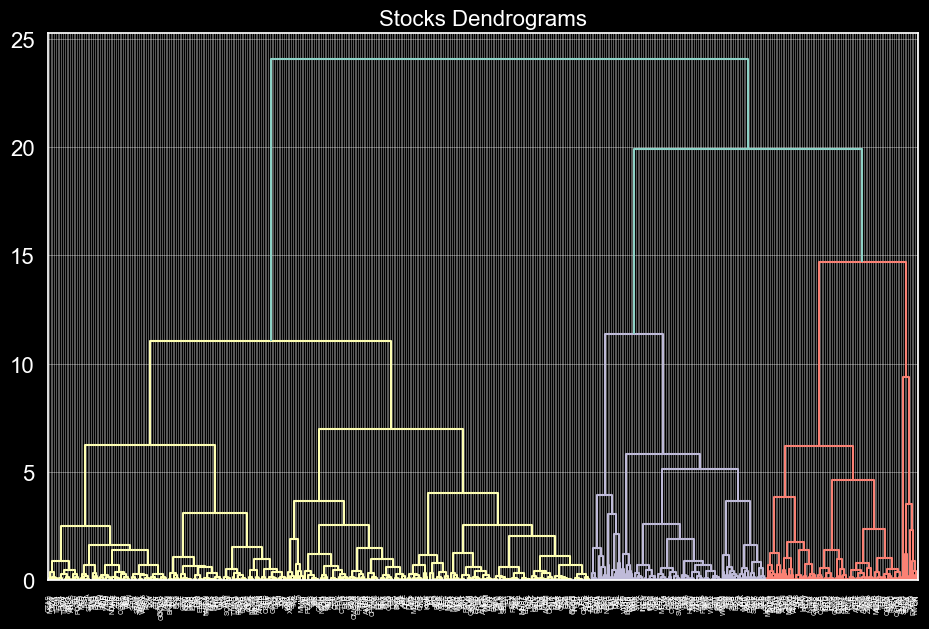

In [596]:
plt.figure(figsize=(10, 7))
plt.title("Stocks Dendrograms")
dendrogram(Z, labels = X.index)

In every dendrogram in the end one big cluster forms, which represents the longest vertical distance without any horizontal line passing through it.

The number of vertical lines that are connected to this horizontal line is the number of clusters. 

We need to choose a cut off threshold in order to finalize our clustering level. 

The output is the cluster labelled for each row of data. As expected from the dendrogram, a cut at 13 gives us four clusters.

In [606]:
d_threshold = 10
clusters = fcluster(Z, d_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
np.sort(chosen_clusters['cluster'].unique())

array([1, 2, 3, 4, 5, 6])

### Clustering and Visualisation

In [609]:
n_clusters = 6
hc = AgglomerativeClustering(
    n_clusters=n_clusters, 
    affinity = 'euclidean', 
    linkage = 'ward'
)
clust_labels1 = hc.fit_predict(X)

Text(0.5, 1.0, 'Hierarchical Clustering')

Text(0.5, 0, 'Mean Return')

Text(0, 0.5, 'Volatility')

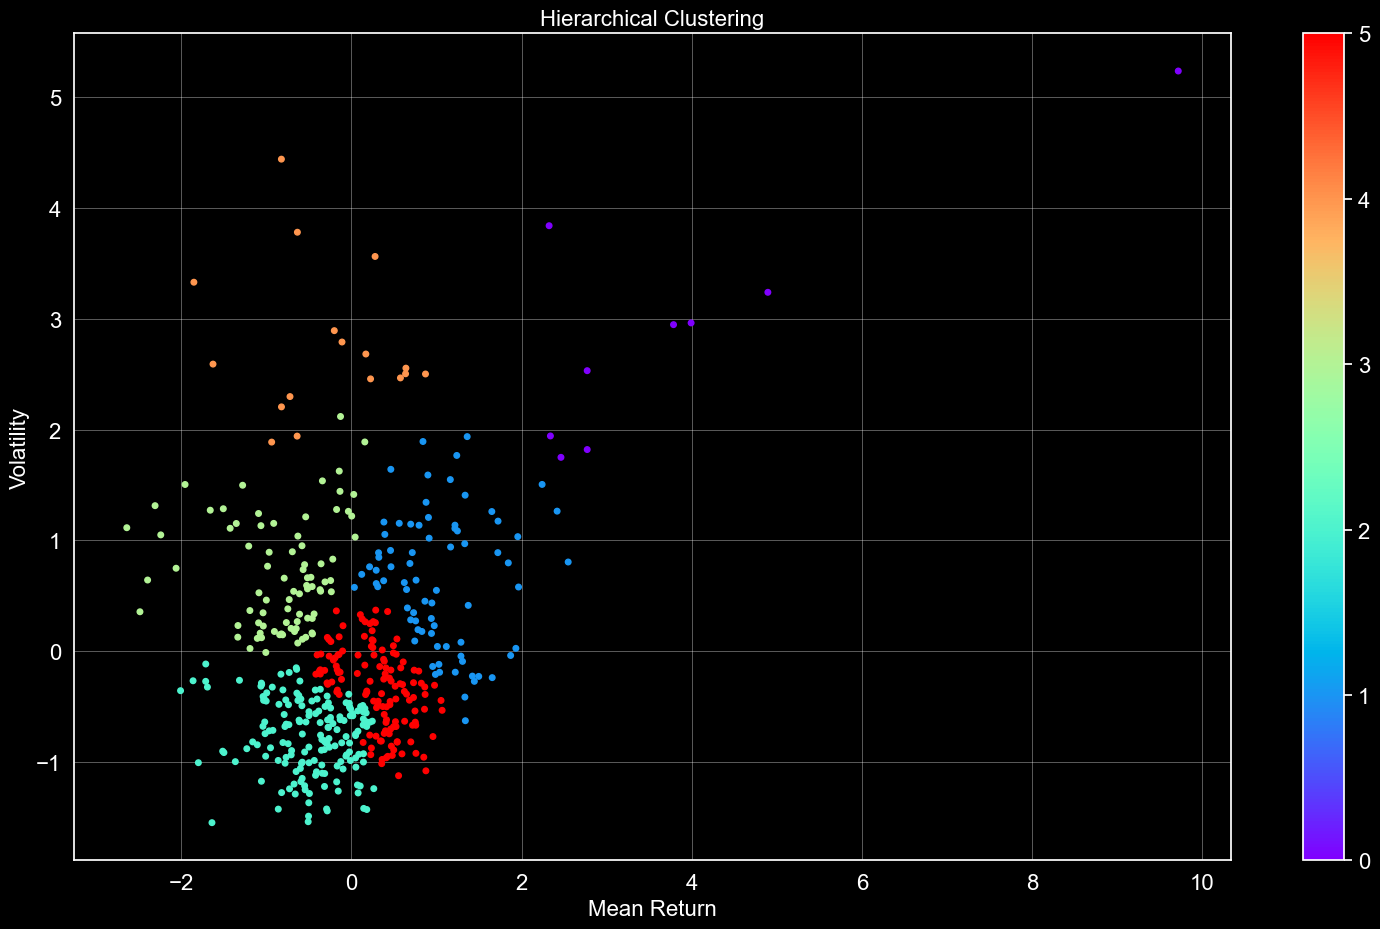

In [610]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

By choosing 6 clusters, just like in our K Means case, we see that the clustering is very similar and distinct. 

## DBSCAN

### Optimize DBSCAN

DBSCAN is a clustering algorithm that works based on density. The most important parameters are:
1. Eps: Max radius of the neighborhood. Data points will be valid neighbors if their mutual distance is less than or equal to the specified epsilon.
   - eps small, a lot of clusters a lot of outliers.
   - eps big, few clusters and less outliers.
2. min_samples: The minimum number of data points within the radius of a neighborhood (ie. epsilon) for the neighborhood to be considered a cluster.
   - min_samples low, a lot of clusters a lot of outliers.
   - min_samples big, few clusters and less outliers.

Optimizing DBSCAN happens either by tuning the epsilon parameter or the minimum number of samples.

We will focus on the epsilon parameter and choose the min_samples as 6.

In any case the quantity that determines our cutoff value for our hyperparameters is the % of outliers DBSCAN detects.

In [ ]:
min_samples = 6

outlier_percent = []

number_of_outliers = []

linspacen = np.linspace(0.001, 10, 100)

for eps in linspacen:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples);
    dbscan.fit(X)

    #total outliers found 
    number_of_outliers += [np.sum(dbscan.labels_ == -1)]

    # Percent of points classified as outliers
    perc_outliers = (np.sum(dbscan.labels_ == -1) / len(dbscan.labels_))* 100
    outlier_percent += [perc_outliers]

<AxesSubplot:>

(0.0, 2.0)

(0.0, 20.0)

Text(0, 0.5, 'Percent of Points classified as Outliers')

Text(0.5, 0, 'epsilon')

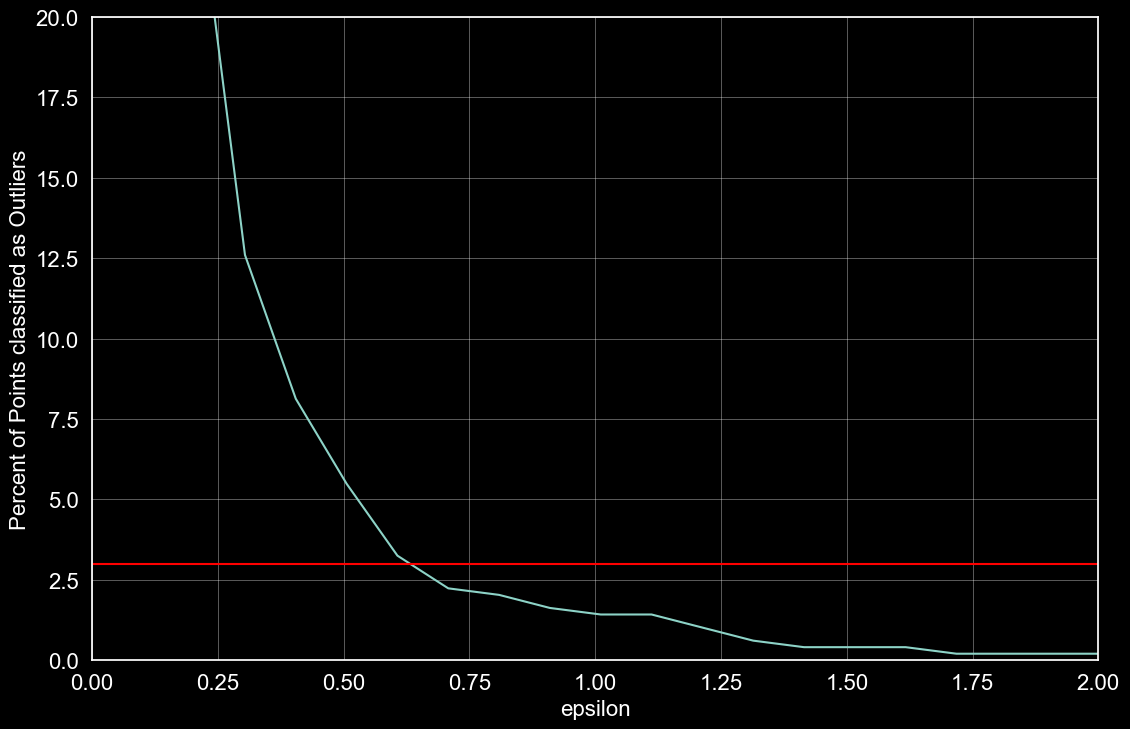

In [638]:
sns.lineplot(x=linspacen, y=outlier_percent)
plt.xlim(0,2)
plt.ylim(0,20)
# Line indicating only 3% outliers
plt.hlines(y=3, xmin=0, xmax=2, color='red')
plt.ylabel('Percent of Points classified as Outliers')
plt.xlabel('epsilon')

### Fix eps=0.6 and min_samples=6

DBSCAN(eps=0.6, min_samples=6)

DBSCAN found 2 clusters and 16 points of noise.


Text(0.5, 1.0, 'DBSCAN')

Text(0.5, 0, 'Mean Return')

Text(0, 0.5, 'Volatility')

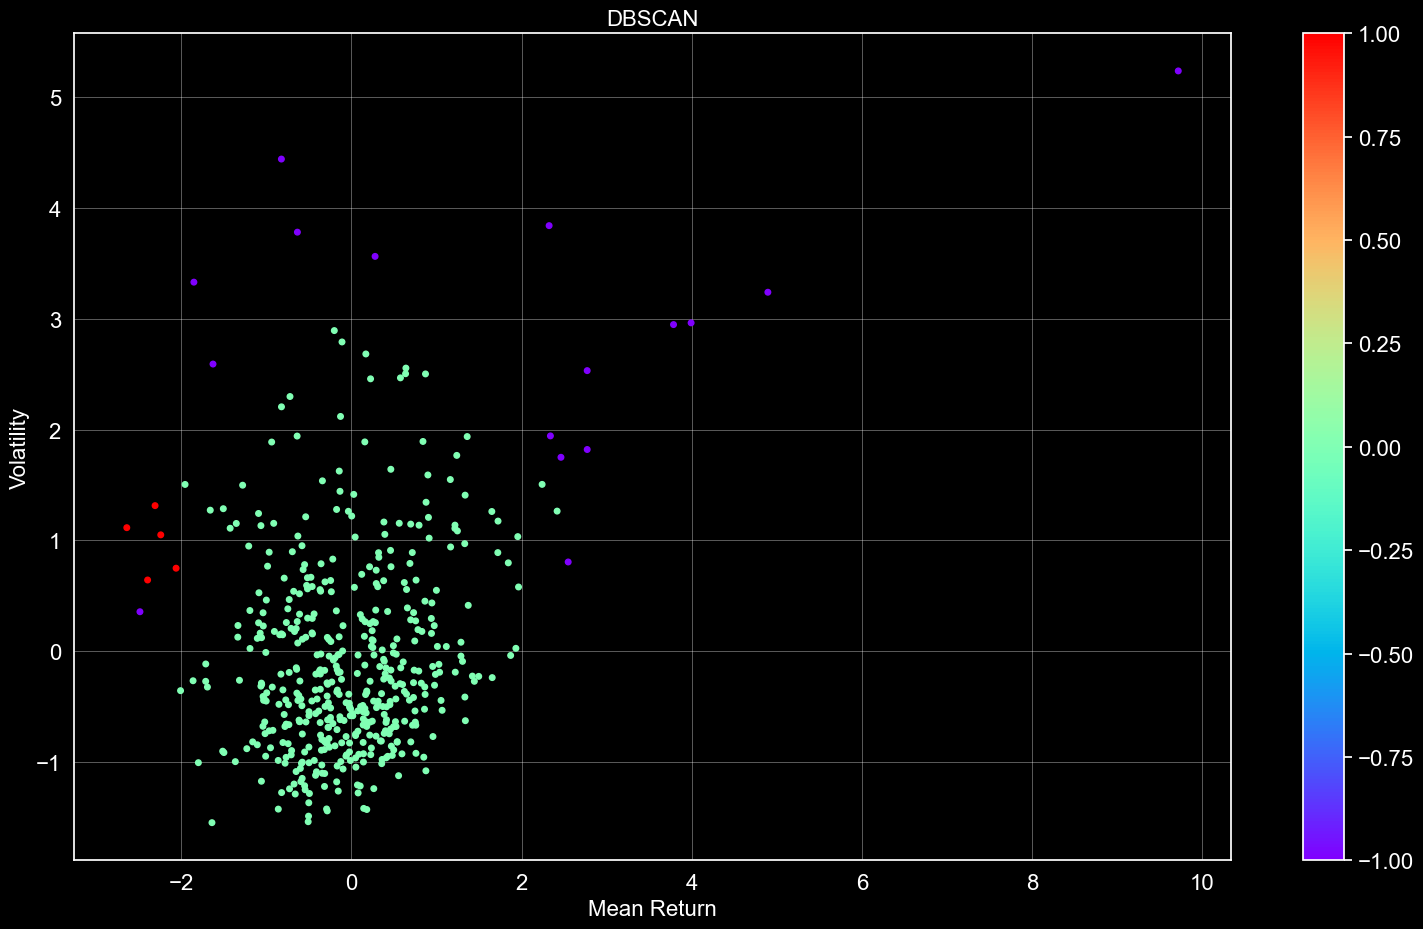

In [640]:
dbscan = DBSCAN(eps=0.60, min_samples=min_samples)
dbscan.fit(X)
print(f'DBSCAN found {len(set(dbscan.labels_) - set([-1]))} clusters and {(dbscan.labels_ == -1).sum()} points of noise.')

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = dbscan.labels_, cmap ="rainbow")
ax.set_title('DBSCAN')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

It seems that at eps=0.6 the rate of % outliers drops drastically.

This is also in agreement with the plot of X. There are not many outliers.

The outliers seem to be categorized roughly in the outer layers of our data.

# Classifier Evaluation

In [649]:
eval_df = pd.DataFrame(
    data = [
        [metrics.silhouette_score(X, kmeans.labels_, metric='euclidean')],
        [metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean')],
        [metrics.silhouette_score(X, dbscan.labels_, metric='euclidean')]
    ],
    index=['kmeans', 'hc', 'dbscan'],
    columns=['Silhouette']   
)
eval_df 

,Silhouette
kmeans,0.35
hc,0.30
dbscan,0.44


The best performing classifer is the DBSCAN one 

In [653]:
eval_df.idxmax()

Silhouette    dbscan
dtype: object

This is obviously a very particular case since our data is 2-D and we can visually inspect the clustering process. 

# Conclusions

We imported, cleaned and preprocess the S&P500 stocks. Only two of them were empty, which is to be expected when scraping the names of wikipedia. Some of them will be outdated/removed.

We trained 3 clustering algorithms K means, Hierarchical clustering and DBSCAN with the close price of 501 stocks. We particularly optimized K means (k=6) and DBSCAN (eps=0.6 min_samples=6) but one can similarly optimize Hierarchical Clustering. The optimization process was strongly visual since our data was 2-D. This is not always the case and optimizing these type of clustering algorithms can mostly be performed wrt to some metric only. 

Nevertheless, we found that the best performing model turn out to be DBSCAN. This was kind of expected since the data was not really convex and it was quite connected/dense. Thus DBSCAN excelled.

# Next Steps

A few next steps can be taken in order to gain further insight such as:
1. Optimizing Hierarchical Clustering wrt the Silhouette coefficient in order to find a proper threshold for the dendrogram.
2. Optimizing DBSCAN in a similar way as the Hierarchical clustering in 1.
3. Try tuning more hyperparameters in K Means like the distance metric.